# Traduccion usando modelos Seq2Seq

Este notebook está fuertemente basado en el tutorial de PyTorch [*NLP From Scratch: Translation with a Sequence to Sequence Network and Attention*](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) creado por Sean Robertson.

Vamos a estar viendo como traducir frases en francés al inglés.

    IN: il est en train de peindre un tableau .
    TRG: he is painting a picture .
    OUT: he is painting a picture .

    IN: pourquoi ne pas essayer ce vin delicieux ?
    TRG: why not try that delicious wine ?
    OUT: why not try that delicious wine ?

    IN: elle n est pas poete mais romanciere .
    TRG: she is not a poet but a novelist .
    OUT: she not not a poet but a novelist .

    IN: vous etes trop maigre .
    TRG: you re too skinny .
    OUT: you re all alone .

... con distintos niveles de éxito.


### Imports

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Preparando los Datos
==================

Los datos para este problema son miles de parejas de sentencias en inglés y francés.

    I am cold.    J'ai froid.

In [2]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2020-11-12 22:32:17--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.34.116, 99.86.34.23, 99.86.34.8, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.34.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.05s   

2020-11-12 22:32:17 (52.3 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.t

In [3]:
# Take a peek at the dataset
dataset = pd.read_csv("data/eng-fra.txt", sep="\t", header=None)
dataset.columns = ["English", "French"]
dataset

,English,French
0,Go.,Va !
1,Run!,Cours !
2,Run!,Courez !
3,Wow!,Ça alors !
4,Fire!,Au feu !
...,...,...
135837,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
135838,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
135839,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
135840,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...


We will represent each word in a language as a one-hot vector (i.e., a giant vector of zeros except for a single one at the index of the word). We will however cheat a bit and trim the data to only use a few thousand words per language.

Vamos a representar cada palabra como un one-hot encoded vector (un índice por palabra). Para esto vamos a crear un vocabulario y limitar el número máximo de palabras para solamente usar unas cuántas miles de palabras por lenguaje. 


![Word encoding](https://drive.google.com/uc?id=1aLm__m9YWaKRZdDmdInE5rT-et0jXTci "Word encoding")



Vamos a necesitar un índice por palabra, para esto (y como hemos hecho antes) vamos a crear un vocabulario. En particular en este caso vamos a  hacer uso de una clase auxiliar `Lang` que tiene:
  - word → index (``word2index``) 
  - index → word (``index2word``)
  - ``word2count`` 

In [4]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Los archivos estan en Unicode, para simplificar los transformamos a ASCII, pasamos todo a minúscula y quitamos la mayor parte de la puntuación.

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicode2ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalize_string(s):
    s = unicode2ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

Para leer los datos necesitamos leer cada línea a la vez, y luego separar cada línea en las dos sentencias que la componen. Todos los archivos que descargamos están en Inglés → Otro Idioma, por lo que si queremos traducir desde Otro Idioma → Inglés tenemos que usar la flag `reverse` para invertir los pares.

In [6]:
def read_langs(lang1, lang2, reverse=False):
    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Como tenemos muchos ejemplos y queremos entrenar algo rápidamente, vamos a recortar los datos a un máximo de 10 palabras y nos quedamos con sentencias que se traducen a la forma "I am", "He is", etc.

In [7]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

El proceso completo para preparar los datos es:

- Leer el archivo, separarlo en líneas y separar cada línea en parejas
- Normalizar y filtrar los textos
- Crear los vocabularios a partir de los pares




In [8]:
def prepare_data(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))

    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))

    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)
print(random.choice(pairs))

Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counted words:
fra 4345
eng 2803
['je vais cuisiner pour vous .', 'i m going to cook for you .']


Modelo
=================

![Seq2Seq Architecture](https://drive.google.com/uc?id=14XIFBXqpos7Z_spBMtK5gyWbl5MJyMud "Seq2Seq Architecture")



Encoder
-----------

![Encoder Network](https://drive.google.com/uc?id=17D4YBVh630jJBo6TVquS2a1R6XmPs3qK "Encoder Network")

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Decoder Simple

![Decoder Network](https://drive.google.com/uc?id=13kddnNWcPFku6SUS4ZbTMnDZLmyB2baD "Decoder Network")

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs):
        output = self.embedding(input).view(1, 1, -1)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        
        return output, hidden, 0.0

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Funciones Auxiliares

### Preparando los datos

Vamos a transformar cada pareja de sentencias a una tupla de tensores con índices. Al crearlos, vamos a agregar el token de EOS en ambos.

In [11]:
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensor_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensors_from_pair(pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Entrenando el modelo
------------------

Para entrenar el modelo, pasamos la sentencia de entrada (palabra a palabra) a través del encoder y nos quedamos con sus outputs y último hidden state. El decoder luego recibe el token de `<SOS>` como primer input y el hidden state del encoder como su hidden state inicial. 

"Teacher Forcing" es el concepto de usar el target real como inputs nuevos para cada paso, en lugar de usar las predicciones del decoder. Esto ayuda a la convergencia pero puede traer inestabilidad si la red es explotada: [inestabilidad](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).

Gracias a la libertad que nos da autograd de PyTorch podemos elegir usar teacher forcing solamente un porcentaje de las veces con un simple if, y nuestros optimizadores funcionan sin alterarse. En particular vamos a usar `teacher_forcing_ratio` de 0.5


In [12]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden
        )
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Funciones auxiliares para contabilizar el tiempo y estimar el tiempo restante.


In [13]:
import time
import math


def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

Todo el proceso de entrenamiento consiste en:

-  Comenzar un timer
-  Inicializar los optimizadores y el costo. Vamos a usar NLLLoss como costo.
-  Crear un set de parejas de entrenamiento
-  Inicializar array vacío para los costos

Luego llamamos a ``train`` muchas veces y ocasionalmente imprimimos el progreso.

In [14]:
def train_iters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [
        tensors_from_pair(random.choice(pairs))
        for i in range(n_iters)
    ]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(
            input_tensor, target_tensor, encoder, decoder,
            encoder_optimizer, decoder_optimizer, criterion
        )
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (
                time_since(start, iter / n_iters),
                iter,
                iter / n_iters * 100,
                print_loss_avg
            ))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

Mostrando los resultados
----------------


In [15]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluación
==========

La evaluacion se hace de igual manera que el entrenamiento, pero, al no tener objetivos, usamos las mismas predicciones del decoder como inputs. Hacemos esto hasta que el decorer genere un token de EOS. 




In [41]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH): # Modelo en Inferencia
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Code to run an evaluation step, without targets for the decoder
        input_tensor = tensor_from_sentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # Feed inputs to the encoder one by one ~3 Lines
        for ei in range(input_length):
          encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
          encoder_outputs[ei] += encoder_output[0, 0] # encoder_output tiene forma (1, 1, hidden_size) -> Nos interesa solo lo que está en hidden_size

        # Initialize decoder input and hidden state ~2 Lines
        decoder_hidden = encoder_hidden
        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
          decoder_output, decoder_hidden, attn = decoder(decoder_input, decoder_hidden, encoder_outputs)
          decoder_attentions[di] = attn

          topv, topi = decoder_output.topk(1)
          if topi.item() == EOS_token:
            break
          else:
            decoded_words.append(output_lang.index2word[topi.item()])
          
          decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [17]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Entrenando y Evaluando
=======================



In [ ]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train_iters(encoder, decoder, 75000, print_every=5000)

In [ ]:
evaluate_randomly(encoder, decoder)

# Attention Decoder
----

Si el decoder solamente recibe el vector de contexto estamos desperdiciando informacion potencialmente valiosa en los outputs del encoder, y forzanzo a que este vector guarde todo lo necesario (que capaz es mucho).

El mecanismo de atencion permite al decoder hacerle foco a diferentes partes del output del encoder para cada paso propio del decoder.
Para esto, primero calculamos un set de "pesos de atención", éstos luego son multiplicados por los outputs del encoder para crear una combinacion pesada. El resultado (llamado `attn_applied`) debería contener información sobre esa parte específica de la entrada y de esa manera ayudar al decoder a elegir la palabra correcta.  

![Attention Diagram](https://i.imgur.com/1152PYf.png "Attention")

Para calcular los pesos de atencion usamos una capa feed-forward, usando el input del decoder y el estado oculto como inputs (concatenados).


![Attention Decoder Network](https://drive.google.com/uc?id=11RbwM-12P_180ijRSbbKDoNjdelmNu4I "Attention Decoder Network")



In [19]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        attn_applied = torch.bmm(
            attn_weights.unsqueeze(0),
            encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

1m 39s (- 23m 17s) (5000 6%) 2.8789
3m 14s (- 21m 7s) (10000 13%) 2.2683
4m 49s (- 19m 16s) (15000 20%) 1.9434
6m 23s (- 17m 34s) (20000 26%) 1.6897
7m 56s (- 15m 53s) (25000 33%) 1.4671
9m 29s (- 14m 14s) (30000 40%) 1.3035
11m 2s (- 12m 36s) (35000 46%) 1.1839
12m 34s (- 11m 0s) (40000 53%) 1.0411
14m 6s (- 9m 24s) (45000 60%) 0.9677
15m 39s (- 7m 49s) (50000 66%) 0.8605
17m 11s (- 6m 15s) (55000 73%) 0.7540
18m 44s (- 4m 41s) (60000 80%) 0.6944
20m 16s (- 3m 7s) (65000 86%) 0.6418
21m 48s (- 1m 33s) (70000 93%) 0.5837
23m 18s (- 0m 0s) (75000 100%) 0.5254


<Figure size 432x288 with 0 Axes>

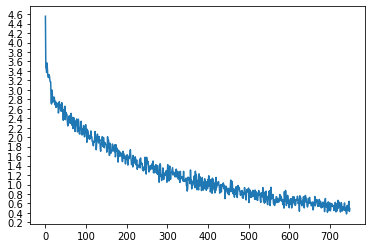

In [20]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(
    hidden_size, output_lang.n_words, dropout_p=0.1
).to(device)

train_iters(encoder, attn_decoder, 75000, print_every=5000)

Visualizando la Atención
---------------------

Una propiedad valiosa del mecanismo de atencion es que es "muy interpretable". Como se usa para ponderar diferentes partes del output del encoder podemos mirar qué hace el modelo en cada paso!

input = elle a cinq ans de moins que moi .
output = she s five years younger than me .
torch.Size([9, 10])


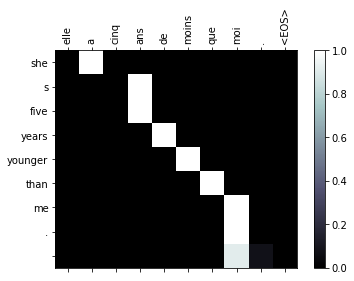

input = elle est trop petit .
output = she s too loud .
torch.Size([6, 10])


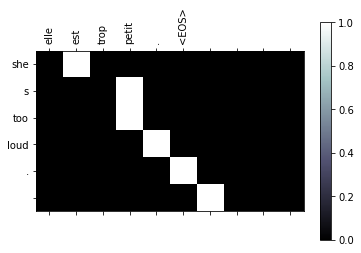

input = je ne crains pas de mourir .
output = i m not afraid to die .
torch.Size([8, 10])


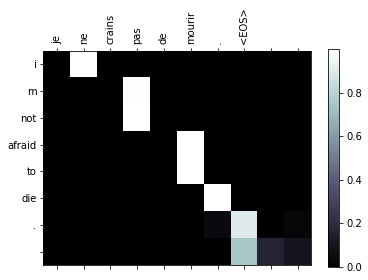

input = c est un jeune directeur plein de talent .
output = he s a talented young young .
torch.Size([8, 10])


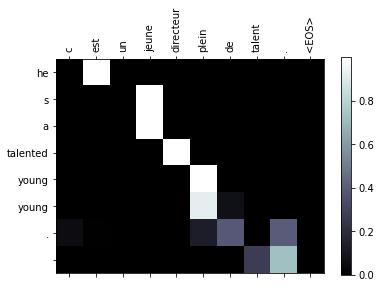

In [42]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(
        [''] + input_sentence.split(' ') + ['<EOS>'], rotation=90
    )
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(
        encoder, attn_decoder, input_sentence
    )
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    print(attentions.shape)
    show_attention(input_sentence, output_words, attentions)


evaluate_and_show_attention("elle a cinq ans de moins que moi .")

evaluate_and_show_attention("elle est trop petit .")

evaluate_and_show_attention("je ne crains pas de mourir .")

evaluate_and_show_attention("c est un jeune directeur plein de talent .")

Ejercicios
=========

-  Otro dataset:

   -  Otros lenguajes
   -  Chat → Respuesta
   -  Pregunta → Respuesta

-  Usar embeddings preentrenados
-  Modificar los modelos

